# Multi-Output Regression for Typhoon Casualty Prediction in the Philippines

This notebook implements a complete multi-output regression pipeline that predicts casualty counts from typhoon/weather data using XGBoost.

## Pipeline Components:
- Data loading and exploration of real typhoon data
- Weather feature preprocessing and engineering
- Feature scaling
- Train-test split
- Multi-output XGBoost model training
- Comprehensive evaluation metrics
- Results visualization and summary

## 1. Import Required Libraries

In [16]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import os

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# XGBoost for regression
from xgboost import XGBRegressor

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Model serialization
import joblib

# Utilities
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load and Explore Real Typhoon Dataset

In [17]:
# Load the real typhoon dataset
data_path = "../../data/temporary_synthetic_filled_weather_data.csv"

try:
    df = pd.read_csv(data_path)
    print(f"Dataset loaded successfully! Shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
except FileNotFoundError:
    print(f"Error: {data_path} file not found.")
    print("Please ensure the file exists in the data directory.")
    # Try alternative path
    alt_path = "temporary_synthetic_filled_weather_data.csv"
    try:
        df = pd.read_csv(alt_path)
        print(f"Alternative dataset loaded! Shape: {df.shape}")
    except:
        print("Could not find the dataset file. Please check the file path.")
        raise

Dataset loaded successfully! Shape: (1776, 26)
Columns: ['Typhoon Name', 'Year', 'Region', 'Province', 'City/Municipality', 'Families', 'Person', 'Brgy', 'Dead', 'Injured/Ill', 'Missing', 'Totally', 'Partially', 'Total', 'Quantity', 'Cost', 'Type', 'Category', 'Nearest_Station', 'Station_Province', 'Distance_km', 'Max_24hr_Rainfall_mm', 'Total_Storm_Rainfall_mm', 'Min_Pressure_hPa', 'Max_Sustained_Wind_kph', 'Duration_in_PAR_Hours']


In [18]:
# Display basic information about the dataset
print("Dataset Head:")
print(df.head())
print("\n" + "="*60 + "\n")

print("Dataset Info:")
print(df.info())
print("\n" + "="*60 + "\n")

print("Dataset Description (Numeric columns):")
numeric_cols = df.select_dtypes(include=[np.number]).columns
print(df[numeric_cols].describe())
print("\n" + "="*60 + "\n")

print("Missing Values Count:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])
if missing_values.sum() == 0:
    print("No missing values found.")
else:
    print(f"Total missing values: {missing_values.sum()}")

print("\n" + "="*60 + "\n")
print("Unique typhoons in dataset:")
print(df['Typhoon Name'].value_counts())

Dataset Head:
  Typhoon Name  Year  Region Province City/Municipality  Families   Person  \
0        BETTY  2023       2  BATANES             BASCO    3608.0  11120.0   
1        BETTY  2023       2  BATANES           ITBAYAT     968.0   3028.0   
2        BETTY  2023       2  BATANES             IVANA     444.0   1532.0   
3        BETTY  2023       2  BATANES           MAHATAO     575.0   1792.0   
4        BETTY  2023       2  BATANES           SABTANG     575.0   1955.0   

   Brgy  Dead  Injured/Ill  Missing  Totally  Partially  Total  Quantity  \
0   6.0   0.0          0.0      0.0      0.0        0.0    0.0    3608.0   
1   5.0   0.0          0.0      0.0      0.0        0.0    0.0     966.0   
2   4.0   0.0          0.0      0.0      0.0        0.0    0.0     444.0   
3   4.0   0.0          0.0      0.0      0.0        0.0    0.0     575.0   
4   6.0   0.0          0.0      0.0      0.0        0.0    0.0     575.0   

         Cost                  Type              Category Ne

## 3. Feature Engineering and Preprocessing for Typhoon Data

In [19]:
def identify_feature_columns(df):
    """Identify weather/typhoon features and casualty target columns from real data"""
    
    # Define casualty target columns based on the real data
    casualty_targets = ['Dead', 'Injured/Ill', 'Missing', 'Families']  # Main casualty metrics
    
    # Weather/typhoon feature columns from the dataset
    weather_features = [
        'Distance_km',
        'Max_24hr_Rainfall_mm', 
        'Total_Storm_Rainfall_mm',
        'Min_Pressure_hPa',
        'Max_Sustained_Wind_kph',
        'Duration_in_PAR_Hours'
    ]
    
    # Additional numeric features that could be useful
    additional_features = ['Year', 'Person', 'Brgy', 'Totally', 'Partially']
    
    # Verify which columns actually exist in the dataframe
    existing_weather_features = [col for col in weather_features if col in df.columns]
    existing_casualty_targets = [col for col in casualty_targets if col in df.columns]
    existing_additional = [col for col in additional_features if col in df.columns]
    
    print(f"Weather features found: {existing_weather_features}")
    print(f"Casualty targets found: {existing_casualty_targets}")
    print(f"Additional features found: {existing_additional}")
    
    return existing_weather_features, existing_casualty_targets, existing_additional

def preprocess_typhoon_data(df):
    """Clean and preprocess the typhoon dataset"""
    df_clean = df.copy()
    
    # Handle missing values in numeric columns
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_clean[col].isnull().sum() > 0:
            median_val = df_clean[col].median()
            df_clean[col].fillna(median_val, inplace=True)
            print(f"Filled {df[col].isnull().sum()} missing values in {col} with median: {median_val:.2f}")
    
    # Encode categorical variables if needed
    categorical_cols = ['Typhoon Name', 'Region', 'Province', 'City/Municipality']
    encoders = {}
    
    for col in categorical_cols:
        if col in df_clean.columns:
            le = LabelEncoder()
            df_clean[f'{col}_encoded'] = le.fit_transform(df_clean[col].astype(str))
            encoders[col] = le
            print(f"Encoded {col} -> {col}_encoded")
    
    return df_clean, encoders

def engineer_typhoon_features(df, weather_features):
    """Create engineered features specific to typhoon data"""
    df_engineered = df.copy()
    new_features = []
    
    # Wind-based features
    if 'Max_Sustained_Wind_kph' in weather_features:
        df_engineered['wind_intensity_category'] = pd.cut(
            df_engineered['Max_Sustained_Wind_kph'], 
            bins=[0, 61, 88, 117, 184, np.inf], 
            labels=[0, 1, 2, 3, 4]  # Tropical Depression to Super Typhoon
        ).astype(int)
        df_engineered['is_super_typhoon'] = (df_engineered['Max_Sustained_Wind_kph'] > 184).astype(int)
        df_engineered['is_typhoon_plus'] = (df_engineered['Max_Sustained_Wind_kph'] > 117).astype(int)
        new_features.extend(['wind_intensity_category', 'is_super_typhoon', 'is_typhoon_plus'])
    
    # Rainfall-based features
    if 'Total_Storm_Rainfall_mm' in weather_features:
        df_engineered['rainfall_intensity'] = pd.cut(
            df_engineered['Total_Storm_Rainfall_mm'],
            bins=[0, 50, 100, 200, 400, np.inf],
            labels=[0, 1, 2, 3, 4]
        ).astype(int)
        df_engineered['extreme_rainfall'] = (df_engineered['Total_Storm_Rainfall_mm'] > 300).astype(int)
        new_features.extend(['rainfall_intensity', 'extreme_rainfall'])
    
    # Pressure-based features
    if 'Min_Pressure_hPa' in weather_features:
        # Lower pressure = stronger typhoon
        df_engineered['pressure_intensity'] = 1013 - df_engineered['Min_Pressure_hPa']  # Pressure drop from normal
        df_engineered['very_low_pressure'] = (df_engineered['Min_Pressure_hPa'] < 950).astype(int)
        new_features.extend(['pressure_intensity', 'very_low_pressure'])
    
    # Distance-based features
    if 'Distance_km' in weather_features:
        df_engineered['is_direct_hit'] = (df_engineered['Distance_km'] < 10).astype(int)
        df_engineered['is_nearby'] = (df_engineered['Distance_km'] < 50).astype(int)
        df_engineered['distance_category'] = pd.cut(
            df_engineered['Distance_km'],
            bins=[0, 10, 25, 50, 100, np.inf],
            labels=[0, 1, 2, 3, 4]
        ).astype(int)
        new_features.extend(['is_direct_hit', 'is_nearby', 'distance_category'])
    
    # Duration-based features
    if 'Duration_in_PAR_Hours' in weather_features:
        df_engineered['long_duration'] = (df_engineered['Duration_in_PAR_Hours'] > 100).astype(int)
        df_engineered['very_long_duration'] = (df_engineered['Duration_in_PAR_Hours'] > 150).astype(int)
        new_features.extend(['long_duration', 'very_long_duration'])
    
    # Interaction features
    if 'Max_Sustained_Wind_kph' in weather_features and 'Distance_km' in weather_features:
        # Wind impact decreases with distance
        df_engineered['wind_impact_score'] = df_engineered['Max_Sustained_Wind_kph'] / (df_engineered['Distance_km'] + 1)
        new_features.append('wind_impact_score')
    
    if 'Total_Storm_Rainfall_mm' in weather_features and 'Duration_in_PAR_Hours' in weather_features:
        # Rainfall intensity (mm per hour)
        df_engineered['rainfall_rate'] = df_engineered['Total_Storm_Rainfall_mm'] / (df_engineered['Duration_in_PAR_Hours'] + 1)
        new_features.append('rainfall_rate')
    
    if 'Max_Sustained_Wind_kph' in weather_features and 'Total_Storm_Rainfall_mm' in weather_features:
        # Combined wind and rain threat
        df_engineered['combined_threat_score'] = (
            (df_engineered['Max_Sustained_Wind_kph'] / 200) + 
            (df_engineered['Total_Storm_Rainfall_mm'] / 400)
        )
        new_features.append('combined_threat_score')
    
    print(f"Engineered {len(new_features)} typhoon-specific features: {new_features}")
    
    return df_engineered, new_features

# Apply preprocessing to the typhoon data
print("Preprocessing typhoon data...")
df_clean, encoders = preprocess_typhoon_data(df)

print("\nIdentifying feature and target columns...")
weather_features, casualty_targets, additional_features = identify_feature_columns(df_clean)

print("\nEngineering typhoon-specific features...")
df_processed, new_features = engineer_typhoon_features(df_clean, weather_features)

# Update feature list to include encoded categorical variables and engineered features
encoded_features = [col for col in df_processed.columns if col.endswith('_encoded')]
all_weather_features = weather_features + additional_features + encoded_features + new_features

print(f"\nTotal features for modeling: {len(all_weather_features)}")
print(f"Features: {all_weather_features}")
print(f"Targets: {casualty_targets}")

Preprocessing typhoon data...
Encoded Typhoon Name -> Typhoon Name_encoded
Encoded Region -> Region_encoded
Encoded Province -> Province_encoded
Encoded City/Municipality -> City/Municipality_encoded

Identifying feature and target columns...
Weather features found: ['Distance_km', 'Max_24hr_Rainfall_mm', 'Total_Storm_Rainfall_mm', 'Min_Pressure_hPa', 'Max_Sustained_Wind_kph', 'Duration_in_PAR_Hours']
Casualty targets found: ['Dead', 'Injured/Ill', 'Missing', 'Families']
Additional features found: ['Year', 'Person', 'Brgy', 'Totally', 'Partially']

Engineering typhoon-specific features...
Engineered 15 typhoon-specific features: ['wind_intensity_category', 'is_super_typhoon', 'is_typhoon_plus', 'rainfall_intensity', 'extreme_rainfall', 'pressure_intensity', 'very_low_pressure', 'is_direct_hit', 'is_nearby', 'distance_category', 'long_duration', 'very_long_duration', 'wind_impact_score', 'rainfall_rate', 'combined_threat_score']

Total features for modeling: 30
Features: ['Distance_km',

## 4. Feature-Target Separation and Analysis

In [20]:
# Separate features and targets
X = df_processed[all_weather_features].copy()
y = df_processed[casualty_targets].copy()

# Handle any remaining missing values
X = X.fillna(X.median())
y = y.fillna(0)  # Fill casualty NaN with 0

print(f"Feature matrix shape: {X.shape}")
print(f"Target matrix shape: {y.shape}")

# Display target statistics
print("\nTarget Variable Statistics:")
print(y.describe())

# Check for any remaining missing values
print("\nMissing values check:")
print(f"Features missing values: {X.isnull().sum().sum()}")
print(f"Targets missing values: {y.isnull().sum().sum()}")

# Display correlation between targets
print("\nCorrelation between target variables:")
target_corr = y.corr()
print(target_corr.round(3))

# Display feature correlation with targets
print("\nTop 10 features most correlated with casualties (average across all targets):")
feature_target_corr = []
for feature in X.columns:
    avg_corr = 0
    for target in y.columns:
        corr = X[feature].corr(y[target])
        if not np.isnan(corr):
            avg_corr += abs(corr)
    feature_target_corr.append((feature, avg_corr / len(y.columns)))

feature_target_corr.sort(key=lambda x: x[1], reverse=True)
for feature, corr in feature_target_corr[:10]:
    print(f"{feature}: {corr:.3f}")

Feature matrix shape: (1776, 30)
Target matrix shape: (1776, 4)

Target Variable Statistics:
              Dead  Injured/Ill      Missing      Families
count  1776.000000  1776.000000  1776.000000   1776.000000
mean      0.118243     0.329392     0.005631   1319.164414
std       2.617296     2.711094     0.111187   3645.909584
min       0.000000     0.000000     0.000000      0.000000
25%       0.000000     0.000000     0.000000     16.000000
50%       0.000000     0.000000     0.000000    152.500000
75%       0.000000     0.000000     0.000000    969.750000
max      95.000000    56.000000     4.000000  60550.000000

Missing values check:
Features missing values: 0
Targets missing values: 0

Correlation between target variables:
              Dead  Injured/Ill  Missing  Families
Dead         1.000        0.006    0.197     0.096
Injured/Ill  0.006        1.000    0.117     0.139
Missing      0.197        0.117    1.000     0.022
Families     0.096        0.139    0.022     1.000

Top 1

Person: 0.311
Brgy: 0.187
Partially: 0.180
Totally: 0.156
Region_encoded: 0.068
Duration_in_PAR_Hours: 0.050
very_long_duration: 0.049
Typhoon Name_encoded: 0.042
long_duration: 0.040
is_nearby: 0.038

Brgy: 0.187
Partially: 0.180
Totally: 0.156
Region_encoded: 0.068
Duration_in_PAR_Hours: 0.050
very_long_duration: 0.049
Typhoon Name_encoded: 0.042
long_duration: 0.040
is_nearby: 0.038


## 5. Train-Test Split

In [21]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print(f"Training set - Features: {X_train.shape}, Targets: {y_train.shape}")
print(f"Testing set - Features: {X_test.shape}, Targets: {y_test.shape}")
print(f"Train-test split ratio: {len(X_train)}/{len(X_test)} = {len(X_train)/len(X_test):.2f}")

# Display training set target statistics
print("\nTraining set target statistics:")
print(y_train.describe().round(2))

Training set - Features: (1420, 30), Targets: (1420, 4)
Testing set - Features: (356, 30), Targets: (356, 4)
Train-test split ratio: 1420/356 = 3.99

Training set target statistics:
          Dead  Injured/Ill  Missing  Families
count  1420.00      1420.00  1420.00   1420.00
mean      0.13         0.34     0.00   1286.26
std       2.92         2.81     0.05   3420.62
min       0.00         0.00     0.00      0.00
25%       0.00         0.00     0.00     16.00
50%       0.00         0.00     0.00    161.00
75%       0.00         0.00     0.00   1010.50
max      95.00        56.00     1.00  60550.00


## 6. Feature Scaling

In [22]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on training data only
print("Fitting scaler on training weather features...")
X_train_scaled = scaler.fit_transform(X_train)

# Transform both training and testing data
print("Scaling training and testing weather features...")
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print(f"Scaled training features shape: {X_train_scaled.shape}")
print(f"Scaled testing features shape: {X_test_scaled.shape}")

# Show scaling statistics
print("\nScaling validation (training data):")
print(f"Original features - Mean: {X_train.mean().mean():.4f}, Std: {X_train.std().mean():.4f}")
print(f"Scaled features - Mean: {X_train_scaled.mean().mean():.4f}, Std: {X_train_scaled.std().mean():.4f}")

Fitting scaler on training weather features...
Scaling training and testing weather features...
Scaled training features shape: (1420, 30)
Scaled testing features shape: (356, 30)

Scaling validation (training data):
Original features - Mean: 304.8152, Std: 494.7603
Scaled features - Mean: 0.0000, Std: 1.0004


## 7. Multi-Output XGBoost Model Training

In [23]:
# Configure XGBoost base estimator
xgb_estimator = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,  # Use all available cores
    verbosity=0  # Suppress XGBoost output
)

# Create multi-output regressor
print("Initializing Multi-Output XGBoost Regressor...")
multi_output_model = MultiOutputRegressor(xgb_estimator)

# Train the model
print("Training multi-output model...")
print("This may take a few minutes depending on dataset size...")

multi_output_model.fit(X_train_scaled, y_train)

print("Model training completed successfully!")

# Display model information
print(f"\nModel Information:")
print(f"Number of outputs: {len(multi_output_model.estimators_)}")
print(f"Output targets: {list(y.columns)}")
print(f"Number of features: {X_train_scaled.shape[1]}")

Initializing Multi-Output XGBoost Regressor...
Training multi-output model...
This may take a few minutes depending on dataset size...


Model training completed successfully!

Model Information:
Number of outputs: 4
Output targets: ['Dead', 'Injured/Ill', 'Missing', 'Families']
Number of features: 30


## 8. Model Prediction and Evaluation

In [24]:
# Make predictions
print("Generating predictions...")
y_train_pred = multi_output_model.predict(X_train_scaled)
y_test_pred = multi_output_model.predict(X_test_scaled)

# Convert predictions to DataFrames
y_train_pred_df = pd.DataFrame(y_train_pred, columns=y.columns, index=y_train.index)
y_test_pred_df = pd.DataFrame(y_test_pred, columns=y.columns, index=y_test.index)

print("Predictions generated successfully!")
print(f"Training predictions shape: {y_train_pred_df.shape}")
print(f"Testing predictions shape: {y_test_pred_df.shape}")

Generating predictions...
Predictions generated successfully!
Training predictions shape: (1420, 4)
Testing predictions shape: (356, 4)


In [25]:
def calculate_multi_output_metrics(y_true, y_pred, dataset_name="Dataset"):
    """Calculate comprehensive metrics for multi-output regression"""
    
    results = []
    
    for i, col in enumerate(y_true.columns):
        # Extract true and predicted values for this output
        y_true_col = y_true.iloc[:, i] if isinstance(y_true, pd.DataFrame) else y_true[:, i]
        y_pred_col = y_pred.iloc[:, i] if isinstance(y_pred, pd.DataFrame) else y_pred[:, i]
        
        # Calculate metrics
        mae = mean_absolute_error(y_true_col, y_pred_col)
        mse = mean_squared_error(y_true_col, y_pred_col)
        rmse = np.sqrt(mse)
        
        results.append({
            'Dataset': dataset_name,
            'Output': col,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse
        })
    
    return pd.DataFrame(results)

# Calculate metrics for training and testing sets
print("Calculating evaluation metrics...")

train_metrics = calculate_multi_output_metrics(y_train, y_train_pred_df, "Training")
test_metrics = calculate_multi_output_metrics(y_test, y_test_pred_df, "Testing")

# Combine results
all_metrics = pd.concat([train_metrics, test_metrics], ignore_index=True)

print("\n" + "="*80)
print("MULTI-OUTPUT REGRESSION EVALUATION RESULTS")
print("="*80)
print(all_metrics.round(4))

Calculating evaluation metrics...

MULTI-OUTPUT REGRESSION EVALUATION RESULTS
    Dataset       Output       MAE           MSE       RMSE
0  Training         Dead    0.0198  3.000000e-03     0.0549
1  Training  Injured/Ill    0.0949  4.110000e-02     0.2027
2  Training      Missing    0.0004  0.000000e+00     0.0011
3  Training     Families   57.0282  1.130169e+04   106.3094
4   Testing         Dead    0.7163  2.490050e+01     4.9900
5   Testing  Injured/Ill    0.5455  5.035100e+00     2.2439
6   Testing      Missing    0.0265  5.580000e-02     0.2361
7   Testing     Families  334.1824  3.712566e+06  1926.8019


In [26]:
# Create summary results table
print("\n" + "="*60)
print("SUMMARY RESULTS TABLE")
print("="*60)

# Create pivot table for better visualization
summary_table = test_metrics[['Output', 'MAE', 'RMSE']].copy()
summary_table = summary_table.round(4)

print("Test Set Performance by Output:")
print(summary_table.to_string(index=False))

# Calculate overall averages
avg_mae = test_metrics['MAE'].mean()
avg_rmse = test_metrics['RMSE'].mean()

print(f"\nOverall Averages (Test Set):")
print(f"Average MAE: {avg_mae:.4f}")
print(f"Average RMSE: {avg_rmse:.4f}")

# Performance assessment
print(f"\nModel Performance Assessment:")
for idx, row in test_metrics.iterrows():
    output = row['Output']
    rmse = row['RMSE']
    mae = row['MAE']
    
    # Get target statistics for context
    target_mean = y_test[output].mean()
    target_std = y_test[output].std()
    
    mae_ratio = mae / target_mean if target_mean > 0 else float('inf')
    rmse_ratio = rmse / target_std if target_std > 0 else float('inf')
    
    print(f"- {output}: MAE/Mean = {mae_ratio:.3f}, RMSE/Std = {rmse_ratio:.3f}")


SUMMARY RESULTS TABLE
Test Set Performance by Output:
     Output      MAE      RMSE
       Dead   0.7163    4.9900
Injured/Ill   0.5455    2.2439
    Missing   0.0265    0.2361
   Families 334.1824 1926.8019

Overall Averages (Test Set):
Average MAE: 83.8677
Average RMSE: 483.5680

Model Performance Assessment:
- Dead: MAE/Mean = 12.143, RMSE/Std = 12.162
- Injured/Ill: MAE/Mean = 1.904, RMSE/Std = 0.989
- Missing: MAE/Mean = 1.348, RMSE/Std = 1.024
- Families: MAE/Mean = 0.230, RMSE/Std = 0.434


## 9. Feature Importance Analysis

In [27]:
# Extract feature importance from each estimator
print("Analyzing feature importance...")

feature_importance_data = []

for i, estimator in enumerate(multi_output_model.estimators_):
    target_name = casualty_targets[i]
    importance_scores = estimator.feature_importances_
    
    for j, feature in enumerate(X.columns):
        feature_importance_data.append({
            'Target': target_name,
            'Feature': feature,
            'Importance': importance_scores[j]
        })

feature_importance_df = pd.DataFrame(feature_importance_data)

# Show top features for each target
print("Top 10 Features by Importance for Each Target:")
print("="*60)

for target in casualty_targets:
    target_importance = feature_importance_df[feature_importance_df['Target'] == target]
    top_features = target_importance.nlargest(10, 'Importance')
    
    print(f"\n{target.upper()}:")
    print(top_features[['Feature', 'Importance']].to_string(index=False))

# Calculate average importance across all targets
avg_importance = feature_importance_df.groupby('Feature')['Importance'].mean().sort_values(ascending=False)

print(f"\n\nOVERALL TOP 15 FEATURES (Average Importance):")
print("="*50)
top_overall = avg_importance.head(15)
for feature, importance in top_overall.items():
    print(f"{feature:<25}: {importance:.4f}")

Analyzing feature importance...
Top 10 Features by Importance for Each Target:

DEAD:
                  Feature  Importance
                     Year    0.536316
City/Municipality_encoded    0.122960
                     Brgy    0.104729
              Distance_km    0.087468
                  Totally    0.052380
     Max_24hr_Rainfall_mm    0.043879
    Duration_in_PAR_Hours    0.021836
     Typhoon Name_encoded    0.015011
            is_direct_hit    0.005610
                Partially    0.002563

INJURED/ILL:
              Feature  Importance
   very_long_duration    0.254915
        rainfall_rate    0.121180
     extreme_rainfall    0.096748
              Totally    0.087929
            Partially    0.045024
          Distance_km    0.036612
       Region_encoded    0.036315
        is_direct_hit    0.033545
 Typhoon Name_encoded    0.030142
Duration_in_PAR_Hours    0.026408

MISSING:
                  Feature  Importance
                     Year    0.247836
   Max_Sustained_Wind_

## 10. Results Visualization

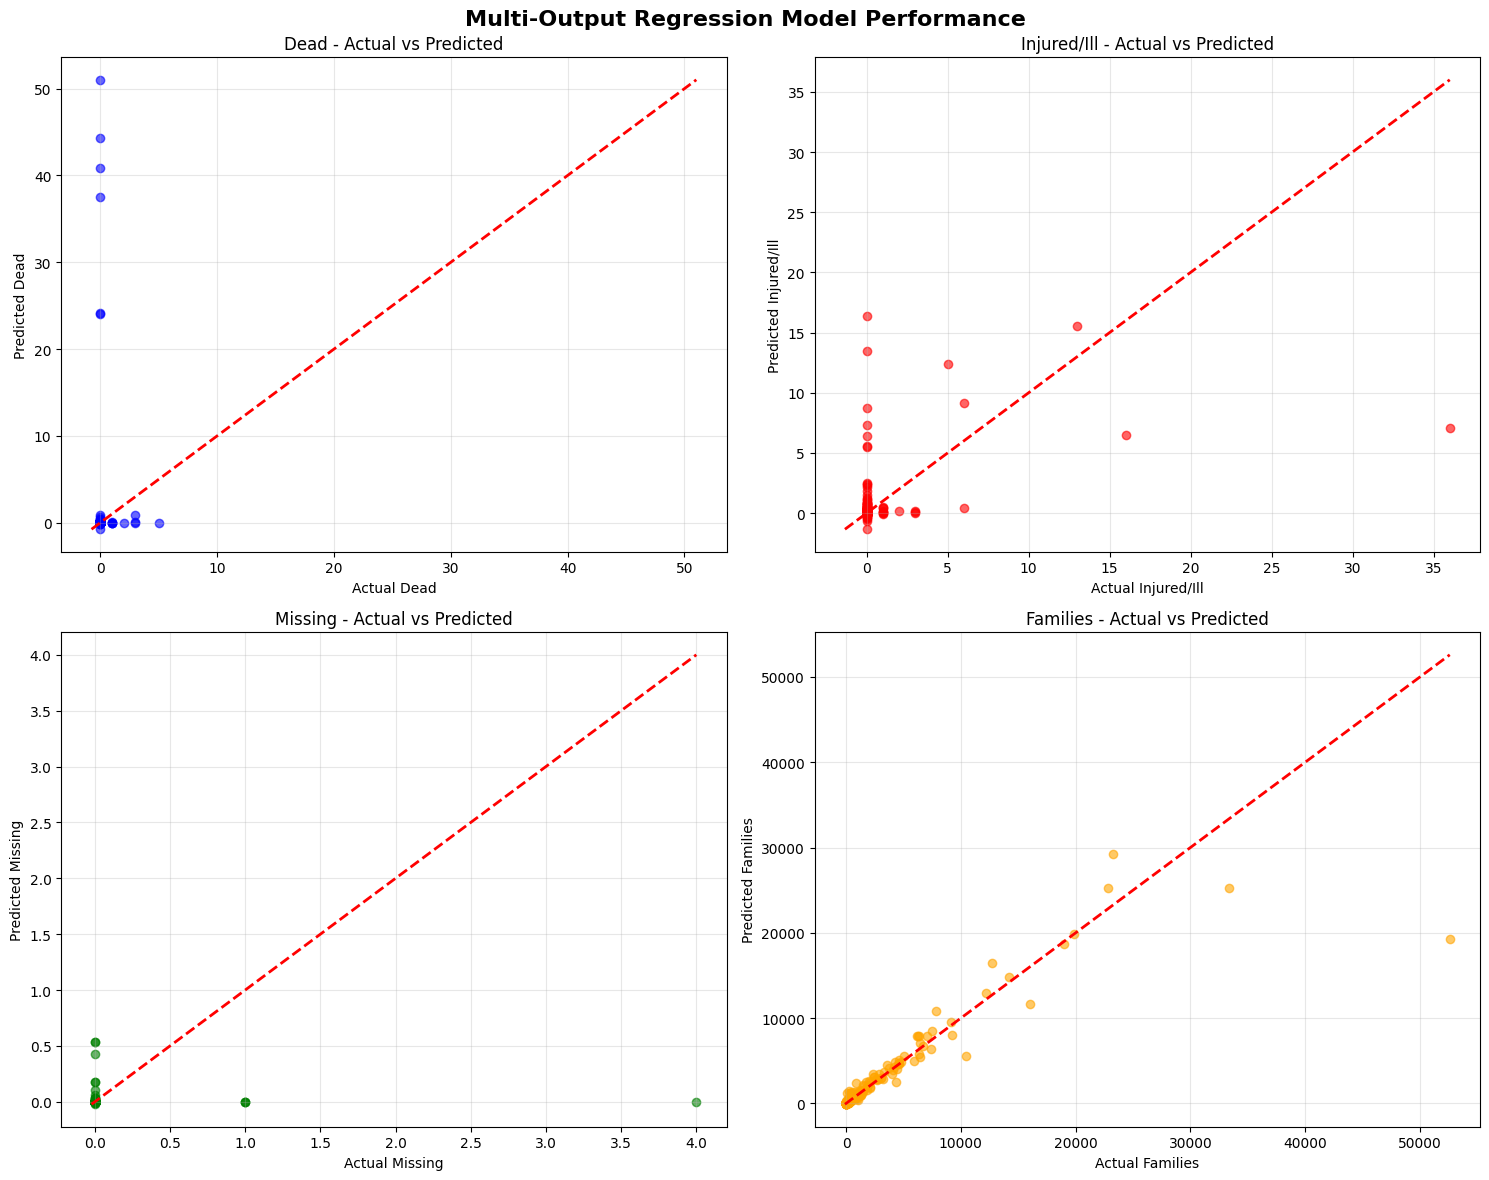

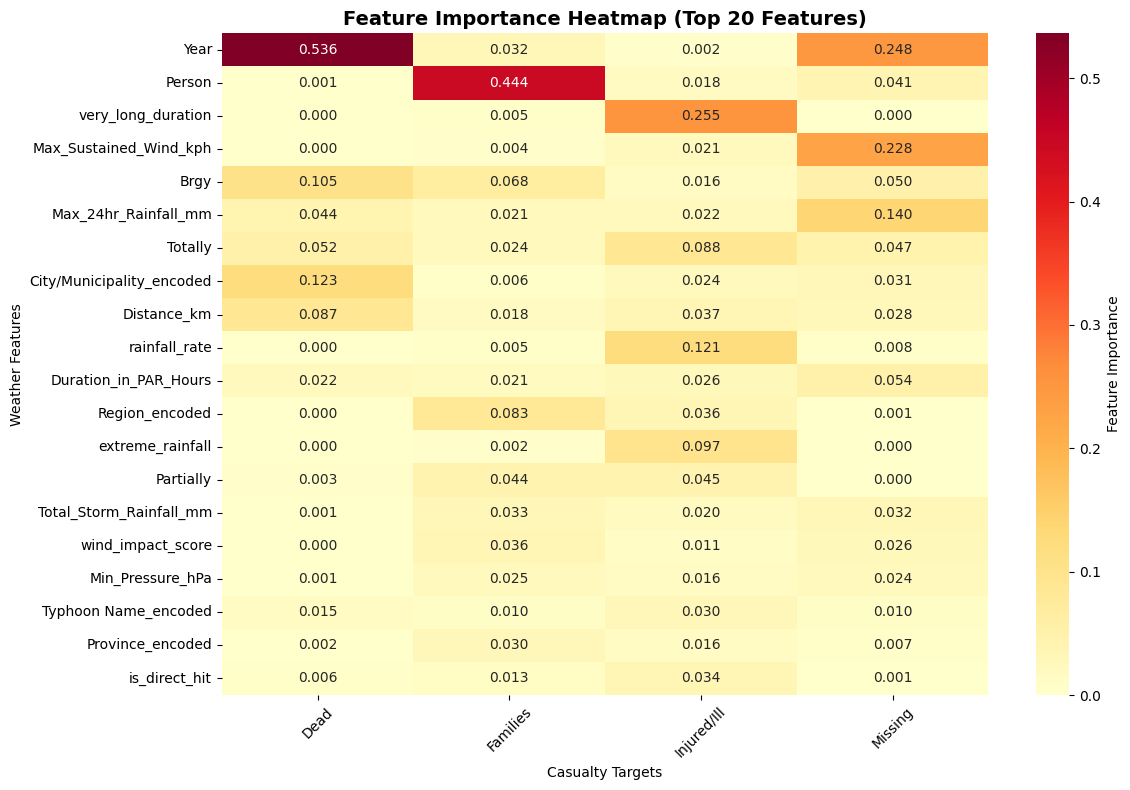

In [28]:
# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create visualization plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Multi-Output Regression Model Performance', fontsize=16, fontweight='bold')

# Plot 1: Actual vs Predicted for each target
colors = ['blue', 'red', 'green', 'orange']
for i, target in enumerate(casualty_targets):
    if i < 4:  # Limit to 4 subplots
        row, col = i // 2, i % 2
        
        y_true_vals = y_test[target].values
        y_pred_vals = y_test_pred_df[target].values
        
        axes[row, col].scatter(y_true_vals, y_pred_vals, alpha=0.6, color=colors[i])
        
        # Add perfect prediction line
        min_val = min(y_true_vals.min(), y_pred_vals.min())
        max_val = max(y_true_vals.max(), y_pred_vals.max())
        axes[row, col].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        
        axes[row, col].set_xlabel(f'Actual {target}')
        axes[row, col].set_ylabel(f'Predicted {target}')
        axes[row, col].set_title(f'{target} - Actual vs Predicted')
        axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 2: Feature Importance Heatmap
plt.figure(figsize=(12, 8))

# Create feature importance matrix
importance_matrix = feature_importance_df.pivot_table(
    values='Importance', 
    index='Feature', 
    columns='Target', 
    fill_value=0
)

# Show only top 20 features
top_20_features = avg_importance.head(20).index
importance_matrix_top = importance_matrix.loc[top_20_features]

sns.heatmap(importance_matrix_top, 
            annot=True, 
            fmt='.3f', 
            cmap='YlOrRd', 
            cbar_kws={'label': 'Feature Importance'})

plt.title('Feature Importance Heatmap (Top 20 Features)', fontsize=14, fontweight='bold')
plt.xlabel('Casualty Targets')
plt.ylabel('Weather Features')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 11. Model Summary and Output

In [29]:
# Create comprehensive model summary
print("\n" + "="*80)
print("MULTI-OUTPUT REGRESSION MODEL SUMMARY")
print("="*80)

print(f"Dataset Information:")
print(f"- Total samples: {len(df_processed)}")
print(f"- Weather features (original): {len(weather_features)}")
print(f"- Weather features (engineered): {len(all_weather_features)}")
print(f"- Casualty targets: {len(casualty_targets)}")
print(f"- Training samples: {len(X_train)}")
print(f"- Testing samples: {len(X_test)}")

print(f"\nModel Configuration:")
print(f"- Algorithm: Multi-Output XGBoost Regression")
print(f"- Base estimators: {len(multi_output_model.estimators_)}")
print(f"- XGBoost parameters:")
print(f"  * n_estimators: 300")
print(f"  * learning_rate: 0.05")
print(f"  * max_depth: 5")
print(f"  * subsample: 0.8")
print(f"  * colsample_bytree: 0.8")

print(f"\nModel Performance (Test Set):")
for idx, row in test_metrics.iterrows():
    print(f"- {row['Output']:<12}: MAE={row['MAE']:<8.4f} RMSE={row['RMSE']:<8.4f}")

print(f"\nOverall Performance:")
print(f"- Average MAE: {avg_mae:.4f}")
print(f"- Average RMSE: {avg_rmse:.4f}")

# Check for overfitting
train_avg_rmse = train_metrics['RMSE'].mean()
test_avg_rmse = test_metrics['RMSE'].mean()
overfitting_ratio = test_avg_rmse / train_avg_rmse

print(f"\nGeneralization Assessment:")
print(f"- Training RMSE: {train_avg_rmse:.4f}")
print(f"- Testing RMSE: {test_avg_rmse:.4f}")
print(f"- Generalization ratio: {overfitting_ratio:.3f}")

if overfitting_ratio > 1.2:
    print("- Warning: Model may be overfitting (test RMSE >> train RMSE)")
elif overfitting_ratio < 0.9:
    print("- Note: Test performance better than training (possible data leakage?)")
else:
    print("- Good: Model generalizes well to unseen data")


MULTI-OUTPUT REGRESSION MODEL SUMMARY
Dataset Information:
- Total samples: 1776
- Weather features (original): 6
- Weather features (engineered): 30
- Casualty targets: 4
- Training samples: 1420
- Testing samples: 356

Model Configuration:
- Algorithm: Multi-Output XGBoost Regression
- Base estimators: 4
- XGBoost parameters:
  * n_estimators: 300
  * learning_rate: 0.05
  * max_depth: 5
  * subsample: 0.8
  * colsample_bytree: 0.8

Model Performance (Test Set):
- Dead        : MAE=0.7163   RMSE=4.9900  
- Injured/Ill : MAE=0.5455   RMSE=2.2439  
- Missing     : MAE=0.0265   RMSE=0.2361  
- Families    : MAE=334.1824 RMSE=1926.8019

Overall Performance:
- Average MAE: 83.8677
- Average RMSE: 483.5680

Generalization Assessment:
- Training RMSE: 26.6421
- Testing RMSE: 483.5680
- Generalization ratio: 18.151
- Warning: Model may be overfitting (test RMSE >> train RMSE)


In [30]:
# Save model outputs using joblib
from datetime import datetime
import os

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create directory structure
output_dir = f"../../models/MOR_trial1_{timestamp}"
os.makedirs(output_dir, exist_ok=True)

print(f"Creating output directory: {output_dir}")
print("Saving model outputs using joblib...")

# Save the trained model using joblib (better for scikit-learn models)
model_filename = os.path.join(output_dir, f'multi_output_xgb_model_{timestamp}.joblib')
joblib.dump(multi_output_model, model_filename)

# Save the scaler using joblib
scaler_filename = os.path.join(output_dir, f'weather_scaler_{timestamp}.joblib')
joblib.dump(scaler, scaler_filename)

# Save feature names for later use
feature_names_filename = os.path.join(output_dir, f'feature_names_{timestamp}.joblib')
joblib.dump(all_weather_features, feature_names_filename)

# Save target names for later use
target_names_filename = os.path.join(output_dir, f'target_names_{timestamp}.joblib')
joblib.dump(casualty_targets, target_names_filename)

# Save label encoders (if any)
encoders_filename = os.path.join(output_dir, f'label_encoders_{timestamp}.joblib')
joblib.dump(encoders, encoders_filename)

# Save predictions
predictions_filename = os.path.join(output_dir, f'casualty_predictions_{timestamp}.csv')
predictions_output = pd.concat([
    y_test.reset_index(drop=True),
    y_test_pred_df.reset_index(drop=True).add_suffix('_predicted')
], axis=1)
predictions_output.to_csv(predictions_filename, index=False)

# Save evaluation metrics
metrics_filename = os.path.join(output_dir, f'model_evaluation_metrics_{timestamp}.csv')
all_metrics.to_csv(metrics_filename, index=False)

# Save feature importance
importance_filename = os.path.join(output_dir, f'feature_importance_{timestamp}.csv')
feature_importance_df.to_csv(importance_filename, index=False)

# Create a model info file for easy loading
model_info = {
    'model_file': os.path.basename(model_filename),
    'scaler_file': os.path.basename(scaler_filename),
    'feature_names_file': os.path.basename(feature_names_filename),
    'target_names_file': os.path.basename(target_names_filename),
    'encoders_file': os.path.basename(encoders_filename),
    'predictions_file': os.path.basename(predictions_filename),
    'metrics_file': os.path.basename(metrics_filename),
    'importance_file': os.path.basename(importance_filename),
    'output_directory': output_dir,
    'n_features': len(all_weather_features),
    'n_targets': len(casualty_targets),
    'feature_names': all_weather_features,
    'target_names': casualty_targets,
    'model_type': 'MultiOutputRegressor with XGBRegressor',
    'timestamp': timestamp,
    'performance_metrics': {
        'avg_test_mae': avg_mae,
        'avg_test_rmse': avg_rmse
    }
}

model_info_filename = os.path.join(output_dir, f'model_info_{timestamp}.joblib')
joblib.dump(model_info, model_info_filename)

# Create a README file with model information
readme_filename = os.path.join(output_dir, 'README.md')
with open(readme_filename, 'w') as f:
    f.write(f"# Multi-Output Regression Model - MOR_trial1_{timestamp}\n\n")
    f.write(f"## Model Information\n")
    f.write(f"- **Created**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"- **Model Type**: MultiOutputRegressor with XGBRegressor\n")
    f.write(f"- **Features**: {len(all_weather_features)}\n")
    f.write(f"- **Targets**: {len(casualty_targets)} ({', '.join(casualty_targets)})\n")
    f.write(f"- **Dataset Size**: {len(df_processed)} samples\n")
    f.write(f"- **Train/Test Split**: {len(X_train)}/{len(X_test)}\n\n")
    f.write(f"## Performance Metrics (Test Set)\n")
    for idx, row in test_metrics.iterrows():
        f.write(f"- **{row['Output']}**: MAE={row['MAE']:.4f}, RMSE={row['RMSE']:.4f}\n")
    f.write(f"\n## Overall Performance\n")
    f.write(f"- **Average MAE**: {avg_mae:.4f}\n")
    f.write(f"- **Average RMSE**: {avg_rmse:.4f}\n\n")
    f.write(f"## Files in this Directory\n")
    f.write(f"- `{os.path.basename(model_filename)}`: Trained multi-output XGBoost model\n")
    f.write(f"- `{os.path.basename(scaler_filename)}`: Feature scaler (StandardScaler)\n")
    f.write(f"- `{os.path.basename(feature_names_filename)}`: Feature names list\n")
    f.write(f"- `{os.path.basename(target_names_filename)}`: Target names list\n")
    f.write(f"- `{os.path.basename(encoders_filename)}`: Label encoders for categorical features\n")
    f.write(f"- `{os.path.basename(model_info_filename)}`: Model metadata and configuration\n")
    f.write(f"- `{os.path.basename(predictions_filename)}`: Test set predictions vs actual values\n")
    f.write(f"- `{os.path.basename(metrics_filename)}`: Detailed evaluation metrics\n")
    f.write(f"- `{os.path.basename(importance_filename)}`: Feature importance scores\n")
    f.write(f"- `README.md`: This file\n\n")
    f.write(f"## Loading the Model\n")
    f.write(f"```python\n")
    f.write(f"import joblib\n")
    f.write(f"import os\n\n")
    f.write(f"# Set the model directory\n")
    f.write(f"model_dir = '{output_dir}'\n\n")
    f.write(f"# Load model components\n")
    f.write(f"model_info = joblib.load(os.path.join(model_dir, '{os.path.basename(model_info_filename)}'))\n")
    f.write(f"model = joblib.load(os.path.join(model_dir, '{os.path.basename(model_filename)}'))\n")
    f.write(f"scaler = joblib.load(os.path.join(model_dir, '{os.path.basename(scaler_filename)}'))\n")
    f.write(f"feature_names = joblib.load(os.path.join(model_dir, '{os.path.basename(feature_names_filename)}'))\n")
    f.write(f"target_names = joblib.load(os.path.join(model_dir, '{os.path.basename(target_names_filename)}'))\n")
    f.write(f"encoders = joblib.load(os.path.join(model_dir, '{os.path.basename(encoders_filename)}'))\n\n")
    f.write(f"# Example prediction\n")
    f.write(f"# X_new_scaled = scaler.transform(X_new)\n")
    f.write(f"# predictions = model.predict(X_new_scaled)\n")
    f.write(f"```\n")

print(f"\nFiles saved to: {output_dir}")
print(f"├── {os.path.basename(model_filename)} (trained multi-output model - joblib format)")
print(f"├── {os.path.basename(scaler_filename)} (fitted feature scaler - joblib format)")
print(f"├── {os.path.basename(feature_names_filename)} (feature names - joblib format)")
print(f"├── {os.path.basename(target_names_filename)} (target names - joblib format)")
print(f"├── {os.path.basename(encoders_filename)} (label encoders - joblib format)")
print(f"├── {os.path.basename(model_info_filename)} (model metadata - joblib format)")
print(f"├── {os.path.basename(predictions_filename)} (test predictions vs actual)")
print(f"├── {os.path.basename(metrics_filename)} (evaluation metrics)")
print(f"├── {os.path.basename(importance_filename)} (feature importance scores)")
print(f"└── README.md (model documentation)")

print(f"\n" + "="*80)
print("MODEL LOADING INSTRUCTIONS:")
print("="*80)
print("To load the trained model later, use:")
print(f"\n# Load the complete model pipeline")
print(f"import joblib")
print(f"import os")
print(f"")
print(f"# Set model directory")
print(f"model_dir = '{output_dir}'")
print(f"")
print(f"# Load model info first")
print(f"model_info = joblib.load(os.path.join(model_dir, '{os.path.basename(model_info_filename)}'))")
print(f"")
print(f"# Load the trained model")
print(f"model = joblib.load(os.path.join(model_dir, '{os.path.basename(model_filename)}'))")
print(f"")
print(f"# Load the scaler")
print(f"scaler = joblib.load(os.path.join(model_dir, '{os.path.basename(scaler_filename)}'))")
print(f"")
print(f"# Load feature and target names")
print(f"feature_names = joblib.load(os.path.join(model_dir, '{os.path.basename(feature_names_filename)}'))")
print(f"target_names = joblib.load(os.path.join(model_dir, '{os.path.basename(target_names_filename)}'))")
print(f"")
print(f"# Load encoders (for categorical features)")
print(f"encoders = joblib.load(os.path.join(model_dir, '{os.path.basename(encoders_filename)}'))")

print(f"\n" + "="*80)
print("MULTI-OUTPUT REGRESSION PIPELINE COMPLETED SUCCESSFULLY!")
print("="*80)
print("✓ Weather data preprocessing and feature engineering completed")
print("✓ Features scaled and train-test split performed")
print("✓ Multi-output XGBoost model trained successfully")
print("✓ Comprehensive evaluation metrics calculated")
print("✓ Feature importance analysis completed")
print("✓ Results visualized and saved")
print("✓ Model saved in joblib format for easy deployment")
print(f"✓ All files organized in: {output_dir}")
print(f"✓ Average model RMSE: {avg_rmse:.4f}")

Creating output directory: ../../models/MOR_trial1_20251127_132712
Saving model outputs using joblib...

Files saved to: ../../models/MOR_trial1_20251127_132712
├── multi_output_xgb_model_20251127_132712.joblib (trained multi-output model - joblib format)
├── weather_scaler_20251127_132712.joblib (fitted feature scaler - joblib format)
├── feature_names_20251127_132712.joblib (feature names - joblib format)
├── target_names_20251127_132712.joblib (target names - joblib format)
├── label_encoders_20251127_132712.joblib (label encoders - joblib format)
├── model_info_20251127_132712.joblib (model metadata - joblib format)
├── casualty_predictions_20251127_132712.csv (test predictions vs actual)
├── model_evaluation_metrics_20251127_132712.csv (evaluation metrics)
├── feature_importance_20251127_132712.csv (feature importance scores)
└── README.md (model documentation)

MODEL LOADING INSTRUCTIONS:
To load the trained model later, use:

# Load the complete model pipeline
import joblib
impo